In [0]:
## Creates a tree like structure to first classify flows as either benignn or malicious 
## Then determines from which family of malware that the flow comes from. This model takes
## into account the metadata of the flow as well as the timings of packets, directions of 
## of packets, and the sequence of packet sizes. This model makes use of a 18-layer RESNET
## with dilation and causal padding. 

In [0]:
import numpy as np
import tensorflow as tf
import six 
import math
from tensorflow.python.training import moving_averages 
import pickle
import tensorflow.keras.backend as K
from sklearn.preprocessing import normalize
import tensorflow_probability as tfp
CONT_FEATURE_SIZE = 158
FINE_METADATA_SIZE = 158+512

In [0]:
def dense_logits_layer(model,input_size, output_size, name,train=True):
  """Fully  connectedt layer."""
  dense = tf.get_variable("weight"+str(name),initializer =tf.random_normal(stddev=0.1, shape =[input_size,output_size]),trainable=train) 
  bias =  tf.get_variable("bias"+str(name),initializer =tf.random_normal(stddev=0.1, shape =[output_size]),trainable=train) 

  model = tf.matmul(tf.cast(model,tf.float32), dense) + bias
  return model

In [0]:
def dense_relu_layer(model,input_size, output_size, drop_rate, name,train=True):
  """Fully Connected Batch Normalization with Dropout and RELU layer."""
  dense = tf.get_variable("weight"+str(name),initializer =tf.random_normal(stddev=0.1, shape =[input_size,output_size]),trainable=train) 
  bias =  tf.get_variable("bias"+str(name),initializer =tf.random_normal(stddev=0.1, shape =[output_size]),trainable=train) 

  model =  tf.nn.relu(tf.matmul(tf.cast(model,tf.float32), dense) + bias)
  model = tf.layers.batch_normalization(model)
  model = tf.nn.dropout(x=model,rate=drop_rate)
  return model

In [0]:
## Method taken from https://github.com/sanjit-bhat/Var-CNN--DynaFlow/blob/master/var_cnn_ensemble.py##
def time_to_batch(x, block_size):
  """Splits time dimension (i.e. dimension 1) of `x` into batches.
  Within each batch element, the `k*block_size` time steps are transposed,
  so that the `k` time steps in each output batch element are offset by
  `block_size` from each other.
  The number of input time steps must be a multiple of `block_size`.
  Args:
    x: Tensor of shape [nb, k*block_size, n] for some natural number k.
    block_size: number of time steps (i.e. size of dimension 1) in the output
      tensor.
  Returns:
    Tensor of shape [nb*block_size, k, n]
  """
  shape = x.get_shape().as_list()
  y = tf.reshape(x, [
      shape[0], shape[1] // block_size, block_size, shape[2]
  ])
  
  y = tf.transpose(y, [0, 2, 1, 3])
  y = tf.reshape(y, [
      shape[0] * block_size, shape[1] // block_size, shape[2]
  ])
  
  y.set_shape([
      mul_or_none(shape[0], block_size), mul_or_none(shape[1], 1. / block_size),
      shape[2]
  ])
  
  return y

In [0]:
## Method taken from https://github.com/sanjit-bhat/Var-CNN--DynaFlow/blob/master/var_cnn_ensemble.py##
def batch_to_time(x, block_size):
  """Inverse of `time_to_batch(x, block_size)`.
  Args:
    x: Tensor of shape [nb*block_size, k, n] for some natural number k.
    block_size: number of time steps (i.e. size of dimension 1) in the output
      tensor.
  Returns:
    Tensor of shape [nb, k*block_size, n].
  """
  shape = x.get_shape().as_list()
  y = tf.reshape(x, [shape[0] // block_size, block_size, shape[1], shape[2]])
  y = tf.transpose(y, [0, 2, 1, 3])
  y = tf.reshape(y, [shape[0] // block_size, shape[1] * block_size, shape[2]])
  y.set_shape([mul_or_none(shape[0], 1. / block_size),
               mul_or_none(shape[1], block_size),
               shape[2]])
  return y

In [0]:
## Method taken from https://github.com/sanjit-bhat/Var-CNN--DynaFlow/blob/master/var_cnn_ensemble.py##
def mul_or_none(a, b):
  """Return the element wise multiplicative of the inputs.
  If either input is None, we return None.
  Args:
    a: A tensor input.
    b: Another tensor input with the same type as a.
  Returns:
    None if either input is None. Otherwise returns a * b.
  """
  if a is None or b is None:
    return None
  return a * b

In [0]:
## Method taken from https://github.com/sanjit-bhat/Var-CNN--DynaFlow/blob/master/var_cnn_ensemble.py##
def conv1d(x,
           num_filters,
           filter_length,
           name,
           dilation=1,
           causal=True,
           kernel_initializer=tf.uniform_unit_scaling_initializer(1.0),
           biases_initializer=tf.constant_initializer(0.0),
           train=True):
  """Fast 1D convolution that supports causal padding and dilation.
  Args:
    x: The [mb, time, channels] float tensor that we convolve.
    num_filters: The number of filter maps in the convolution.
    filter_length: The integer length of the filter.
    name: The name of the scope for the variables.
    dilation: The amount of dilation.
    causal: Whether or not this is a causal convolution.
    kernel_initializer: The kernel initialization function.
    biases_initializer: The biases initialization function.
  Returns:
    y: The output of the 1D convolution.
  """
  batch_size, length, num_input_channels = x.get_shape().as_list()
  assert length % dilation == 0

  kernel_shape = [1, filter_length, num_input_channels, num_filters]
  strides = [1, 1, 1, 1]
  biases_shape = [num_filters]
  padding = 'VALID' if causal else 'SAME'

  with tf.variable_scope(name):
    weights = tf.get_variable(
        'W', shape=kernel_shape, initializer=kernel_initializer,trainable=train)
    biases = tf.get_variable(
        'biases', shape=biases_shape, initializer=biases_initializer,trainable=train)

  x_ttb = time_to_batch(x, dilation)
  if filter_length > 1 and causal:
    x_ttb = tf.pad(x_ttb, [[0, 0], [filter_length - 1, 0], [0, 0]])

  x_ttb_shape = x_ttb.get_shape().as_list()
  x_4d = tf.reshape(x_ttb, [x_ttb_shape[0], 1,
                            x_ttb_shape[1], num_input_channels])
  y = tf.nn.conv2d(x_4d, weights, strides, padding=padding)
  y = tf.nn.bias_add(y, biases)
  y_shape = y.get_shape().as_list()
  y = tf.reshape(y, [y_shape[0], y_shape[2], num_filters])
  y = batch_to_time(y, dilation)
  y.set_shape([batch_size, length, num_filters])
  return y

W0810 09:13:20.196003 140253529896832 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/util/deprecation.py:507: UniformUnitScaling.__init__ (from tensorflow.python.ops.init_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


In [0]:
## Method taken from https://github.com/sanjit-bhat/Var-CNN--DynaFlow/blob/master/var_cnn_ensemble.py##
def dir_conv_layer(model, num_filters, rate, name,train=True):
  """Conv-ReLU-Batch Normalization layer for direction. This uses dilated convolutions."""
  model = conv1d(model,num_filters=num_filters,filter_length=3,name =name, dilation = rate,causal=True,train=train)
  model = tf.nn.relu(model)
  model = tf.layers.batch_normalization(model,name= name+"batch_norm")
  # exponentially increase dilated convolution receptive field
  # receptive field size loops back around when rate = 16 to create [1...8] block
  rate *= 2
  if rate == 16:
      rate = 1
  return model, rate

In [0]:
def dir_conv_block(model, nb_layers, nb_filters, rate, name,train=True):
  with tf.variable_scope("dir_model",reuse=tf.AUTO_REUSE):
    with tf.device('/device:GPU:0'):
      """Creates multiple conv layers followed by max pooling and dropout layers."""
      for i in range(nb_layers):
        model, rate = dir_conv_layer(model,nb_filters, rate,name="conv_dir"+str(i)+name,train=train)
      model = tf.nn.max_pool1d(model,ksize=2,strides=2,padding='VALID',data_format="NCW",name="conv_max_pool_dir"+name)
      model = tf.nn.dropout(x=model,rate=(0.1))
      return model, rate

In [0]:
def time_conv_layer(model, num_filters, name,train=True):
  """Conv-ReLU-Batch Normalization layer for direction. This uses dilated convolutions."""
  model = conv1d(model,num_filters=num_filters,filter_length=3,name =name,causal=True,train=train)
  model = tf.nn.relu(model)
  model = tf.layers.batch_normalization(model,name= name+"batch_norm")
  return model 

def time_conv_block(model, nb_layers, nb_filters,name,train=True):
  """Creates multiple conv layers followed by max pooling and dropout layers."""
  for i in range(nb_layers):
    model = time_conv_layer(model, nb_filters,name="conv_time"+str(i)+name,train=train)
  model = tf.nn.max_pool1d(model,ksize=2,strides=2,padding='VALID',data_format="NCW",name="conv_max_pool_time"+name)
  model = tf.nn.dropout(x=model,rate=0.1)
  return model

In [0]:
def get_logits_meta(x,input_shape,model_scope, name,train=True):
  with  tf.variable_scope(model_scope,reuse=tf.AUTO_REUSE):
    with  tf.device('/device:GPU:0'):
      W_dense4_class = tf.get_variable(name+"dense4_sec",initializer =tf.random_normal(stddev=0.1, shape =[input_shape,784] ),trainable=train)
      b_dense4_class = tf.get_variable(name+"bias4_sec",initializer =tf.random_normal(stddev=0.1,shape=[784]),trainable=train)
      h_fc4_class = tf.nn.relu(tf.matmul(tf.cast(x,tf.float32), W_dense4_class) + b_dense4_class)

      reshape_1_class = tf.reshape(h_fc4_class,[BATCH_SHAPE,28,28,1])
      conv2d_1_weight = tf.get_variable(name+"conv2d_1_dense",initializer =tf.random_normal(stddev=0.1, shape =[5, 5, 1, 32]),trainable=train)
      conv2d_1_bias = tf.get_variable(name+"conv2d_1_bias",initializer =tf.random_normal(stddev=0.1, shape= [32]),trainable=train)
      conv2d_1_class = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(reshape_1_class,
                                                  conv2d_1_weight,
                                                  strides =[1,1,1,1],
                                                  padding='SAME'),
                                      conv2d_1_bias))

      maxpool2d_1_class = tf.nn.max_pool(conv2d_1_class,
                                       ksize=[1, 2, 2, 1], 
                                       strides=[1, 2, 2, 1],
                                padding='SAME')
      conv2d_2_weight = tf.get_variable(name+"conv2d_2_dense",initializer =tf.random_normal(stddev=0.1, shape =[5, 5, 32, 64]),trainable=train)
      conv2d_2_bias = tf.get_variable(name+"conv2d_2_bias",initializer =tf.random_normal(stddev=0.1, shape=[64]),trainable=train)
      conv2d_2_class = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(maxpool2d_1_class,
                                                  conv2d_2_weight,
                                                  strides =[1,1,1,1],
                                                  padding='SAME'),
                                      conv2d_2_bias))

      maxpool2d_2_class = tf.nn.max_pool(conv2d_2_class,
                                       ksize=[1, 2, 2, 1], 
                                       strides=[1, 2, 2, 1],
                                padding='SAME')

      reshape_2_class = tf.reshape(maxpool2d_2_class,[BATCH_SHAPE,-1])
      W_dense5_class = tf.get_variable(name+"dense5_sec",initializer =tf.random_normal(stddev=0.1,shape=[7*7*64,1024]),trainable=train)
      b_dense5_class = tf.get_variable(name+"bias5_sec",initializer =tf.random_normal(stddev=0.1,shape=[1024]),trainable=train)
      out_final_logits = tf.nn.bias_add(tf.matmul(reshape_2_class, W_dense5_class),b_dense5_class)
      return out_final_logits

In [0]:
def get_dir_logits(dir_x_, dir_meta_x_,train=True):
  with  tf.variable_scope("dir_model",reuse=tf.AUTO_REUSE):
    with  tf.device('/device:GPU:0'):
      dir_x = tf.expand_dims(dir_x_,2)
      dilation_rate = 1
      cnn_model, dilation_rate = dir_conv_block(dir_x, 2, 4, dilation_rate, name = "dir_first_block",train=train)
      cnn_model, dilation_rate = dir_conv_block(cnn_model, 2, 8, dilation_rate, name="dir_second_block",train=train)
      cnn_model, dilation_rate = dir_conv_block(cnn_model, 2, 8, dilation_rate, name= "dir_third_block",train=train)
      cnn_model, dilation_rate = dir_conv_block(cnn_model, 3, 16, dilation_rate, name="dir_fourth_block",train=train)
      cnn_model, dilation_rate = dir_conv_block(cnn_model, 3, 16, dilation_rate,"dir_fifth_block",train=train)
      cnn_output = tf.layers.flatten(cnn_model)
      cnn_output = dense_relu_layer(cnn_output,512, 1024, 0.4,name= "dir_first_dense_layer",train=train)
      
      metadata_output = get_logits_meta(dir_meta_x_, METADATA_SIZE,"dir_model", "size_model",train=train)
      # concatenate before second dense layer
      combined = tf.concat([cnn_output, metadata_output],axis =1)
      combined = dense_relu_layer(combined, 2048, 1024, 0.5, name= "dir_combined",train=train)
      combined = tf.nn.dropout(combined, rate =0.5)
      #dir_combined_output = dense_logits_layer(combined, 1024, 2, 0.5, name= "dir_combined_out",train=train)
      return combined

In [0]:
def get_fine_dir_logits(dir_x_, dir_meta_x_,train=True):
  with  tf.variable_scope("fine_dir_model",reuse=tf.AUTO_REUSE):
    with  tf.device('/device:GPU:0'):
      dir_x = tf.expand_dims(dir_x_,2)
      dilation_rate = 1
      cnn_model, dilation_rate = dir_conv_block(dir_x, 2, 4, dilation_rate, name = "fine_dir_first_block",train=train)
      cnn_model, dilation_rate = dir_conv_block(cnn_model, 2, 8, dilation_rate, name="fine_dir_second_block",train=train)
      cnn_model, dilation_rate = dir_conv_block(cnn_model, 2, 8, dilation_rate, name= "fine_dir_third_block",train=train)
      cnn_model, dilation_rate = dir_conv_block(cnn_model, 3, 16, dilation_rate, name="fine_dir_fourth_block",train=train)
      cnn_model, dilation_rate = dir_conv_block(cnn_model, 3, 16, dilation_rate,"fine_dir_fifth_block",train=train)
      cnn_output = tf.layers.flatten(cnn_model)
      cnn_output = dense_relu_layer(cnn_output,512, 1024, 0.4,name= "fine_dir_first_dense_layer",train=train)
      
      metadata_output = get_logits_meta(dir_meta_x_, FINE_METADATA_SIZE,"fine_dir_model", "size_model",train=train)
      # concatenate before second dense layer
      combined = tf.concat([cnn_output, metadata_output],axis =1)
      combined = dense_relu_layer(combined, 2048, 1024, 0.5, name= "fine_dir_combined",train=train)
      combined = tf.nn.dropout(combined, rate =0.5)
      #dir_combined_output = dense_logits_layer(combined, 1024, 2, 0.5, name= "dir_combined_out",train=train)
      return combined

In [0]:
def get_fine_size_logits(size_x_,size_meta_x_,train=True):
  with  tf.variable_scope("size_model",reuse=tf.AUTO_REUSE):
    with  tf.device('/device:GPU:0'):
      size_x = tf.expand_dims(size_x_,2)
      cnn_model = time_conv_block(size_x, 2, 4, name = "fine_size_first_block",train=train)
      cnn_model = time_conv_block(cnn_model, 2, 8, name="fine_size_second_block",train=train)
      cnn_model = time_conv_block(cnn_model, 2, 8, name= "fine_size_third_block",train=train)
      cnn_model = time_conv_block(cnn_model, 3, 16, name="fine_size_fourth_block",train=train)
      cnn_model = time_conv_block(cnn_model, 3, 16,"fine_size_fifth_block",train=train)
      cnn_output = tf.layers.flatten(cnn_model)
      cnn_output = dense_relu_layer(cnn_output,512, 1024, 0.4,name= "fine_size_first_dense_layer",train=train)
      
      metadata_output = get_logits_meta(size_meta_x_, FINE_METADATA_SIZE,"fine_size_model", "size_model",train=train)
      # concatenate before second dense layer
      combined = tf.concat([cnn_output, metadata_output],axis =1)
      combined = dense_relu_layer(combined, 2048, 1024, 0.5, name= "fine_size_combined",train=train)
      combined = tf.nn.dropout(combined, rate =0.5)
      #size_combined_output = dense_logits_layer(combined, 1024, 2, 0.5, name= "size_combined_out",train=train)
      return combined

In [0]:
def get_size_logits(size_x_,size_meta_x_,train=True):
  with  tf.variable_scope("size_model",reuse=tf.AUTO_REUSE):
    with  tf.device('/device:GPU:0'):
      size_x = tf.expand_dims(size_x_,2)
      cnn_model = time_conv_block(size_x, 2, 4, name = "size_first_block",train=train)
      cnn_model = time_conv_block(cnn_model, 2, 8, name="size_second_block",train=train)
      cnn_model = time_conv_block(cnn_model, 2, 8, name= "size_third_block",train=train)
      cnn_model = time_conv_block(cnn_model, 3, 16, name="size_fourth_block",train=train)
      cnn_model = time_conv_block(cnn_model, 3, 16,"size_fifth_block",train=train)
      cnn_output = tf.layers.flatten(cnn_model)
      cnn_output = dense_relu_layer(cnn_output,512, 1024, 0.4,name= "size_first_dense_layer",train=train)
      
      metadata_output = get_logits_meta(size_meta_x_, METADATA_SIZE,"size_model", "size_model",train=train)
      # concatenate before second dense layer
      combined = tf.concat([cnn_output, metadata_output],axis =1)
      combined = dense_relu_layer(combined, 2048, 1024, 0.5, name= "size_combined",train=train)
      combined = tf.nn.dropout(combined, rate =0.5)
      #size_combined_output = dense_logits_layer(combined, 1024, 2, 0.5, name= "size_combined_out",train=train)
      return combined

In [0]:
def get_fine_time_logits(time_x_,time_meta_x_,train=True):
  with  tf.variable_scope("fine_time_model",reuse=tf.AUTO_REUSE):
    with  tf.device('/device:GPU:0'):
      time_x = tf.expand_dims(time_x_,2)
      cnn_model = time_conv_block(time_x, 2, 4, name = "fine_time_first_block",train=train)
      cnn_model = time_conv_block(cnn_model, 2, 8, name="fine_time_second_block",train=train)
      cnn_model = time_conv_block(cnn_model, 2, 8, name= "fine_time_third_block",train=train)
      cnn_model = time_conv_block(cnn_model, 3, 16, name="fine_time_fourth_block",train=train)
      cnn_model = time_conv_block(cnn_model, 3, 16,"fine_time_fifth_block",train=train)
      cnn_output = tf.layers.flatten(cnn_model)
      cnn_output = dense_relu_layer(cnn_output,512, 1024, 0.4,name= "fine_time_first_dense_layer",train=train)
      
      metadata_output = dense_relu_layer(time_meta_x_,FINE_METADATA_SIZE, 1024, 0., name = "fine_time_metadata_first_out",train=train)  # consider this the embedding of all the metadata
      # concatenate before second dense layer
      combined = tf.concat([cnn_output, metadata_output],axis =1)
      combined = dense_relu_layer(combined, 2048, 1024, 0.5, name= "fine_time_combined",train=train)
      combined = tf.nn.dropout(combined, rate =0.5)
      #time_combined_output = dense_logits_layer(combined, 1024, 2, 0.5, name= "time_combined_out",train=train)
      return combined

In [0]:
def get_time_logits(time_x_,time_meta_x_,train=True):
  with  tf.variable_scope("time_model",reuse=tf.AUTO_REUSE):
    with  tf.device('/device:GPU:0'):
      time_x = tf.expand_dims(time_x_,2)
      cnn_model = time_conv_block(time_x, 2, 4, name = "time_first_block",train=train)
      cnn_model = time_conv_block(cnn_model, 2, 8, name="time_second_block",train=train)
      cnn_model = time_conv_block(cnn_model, 2, 8, name= "time_third_block",train=train)
      cnn_model = time_conv_block(cnn_model, 3, 16, name="time_fourth_block",train=train)
      cnn_model = time_conv_block(cnn_model, 3, 16,"time_fifth_block",train=train)
      cnn_output = tf.layers.flatten(cnn_model)
      cnn_output = dense_relu_layer(cnn_output,512, 1024, 0.4,name= "time_first_dense_layer",train=train)
      
      metadata_output = dense_relu_layer(time_meta_x_,METADATA_SIZE, 1024, 0., name = "time_metadata_first_out",train=train)  # consider this the embedding of all the metadata
      # concatenate before second dense layer
      combined = tf.concat([cnn_output, metadata_output],axis =1)
      combined = dense_relu_layer(combined, 2048, 1024, 0.5, name= "time_combined",train=train)
      combined = tf.nn.dropout(combined, rate =0.5)
      #time_combined_output = dense_logits_layer(combined, 1024, 2, 0.5, name= "time_combined_out",train=train)
      return combined

In [0]:
def get_conv_fine_logits(x,y,return_embedding=False):
  with  tf.variable_scope("time_model",reuse=tf.AUTO_REUSE):
    with  tf.device('/device:GPU:0'):
      inp = tf.concat([x,y],axis=1)
      W_dense4_class = tf.get_variable("dense4_sec",initializer =tf.random_normal(stddev=0.1, shape =[158+512,784] ))
      b_dense4_class = tf.get_variable("bias4_sec",initializer =tf.random_normal(stddev=0.1,shape=[784]))
      h_fc4_class = tf.nn.relu(tf.matmul(tf.cast(inp,tf.float32), W_dense4_class) + b_dense4_class)

      reshape_1_class = tf.reshape(h_fc4_class,[BATCH_SHAPE,28,28,1])
      conv2d_1_weight = tf.get_variable("conv2d_1_dense",initializer =tf.random_normal(stddev=0.1, shape =[5, 5, 1, 32]))
      conv2d_1_bias = tf.get_variable("conv2d_1_bias",initializer =tf.random_normal(stddev=0.1, shape= [32]))
      conv2d_1_class = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(reshape_1_class,
                                                  conv2d_1_weight,
                                                  strides =[1,1,1,1],
                                                  padding='SAME'),
                                      conv2d_1_bias))

      maxpool2d_1_class = tf.nn.max_pool(conv2d_1_class,
                                       ksize=[1, 2, 2, 1], 
                                       strides=[1, 2, 2, 1],
                                padding='SAME')
      conv2d_2_weight = tf.get_variable("conv2d_2_dense",initializer =tf.random_normal(stddev=0.1, shape =[5, 5, 32, 64]))
      conv2d_2_bias = tf.get_variable("conv2d_2_bias",initializer =tf.random_normal(stddev=0.1, shape=[64]))
      conv2d_2_class = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(maxpool2d_1_class,
                                                  conv2d_2_weight,
                                                  strides =[1,1,1,1],
                                                  padding='SAME'),
                                      conv2d_2_bias))

      maxpool2d_2_class = tf.nn.max_pool(conv2d_2_class,
                                       ksize=[1, 2, 2, 1], 
                                       strides=[1, 2, 2, 1],
                                padding='SAME')

      reshape_2_class = tf.reshape(maxpool2d_2_class,[BATCH_SHAPE,-1])
      drop_one = tf.nn.dropout(reshape_2_class,rate=0.2)
      W_dense5_class = tf.get_variable("dense5_sec",initializer =tf.random_normal(stddev=0.1,shape=[7*7*64,1024]))
      b_dense5_class = tf.get_variable("bias5_sec",initializer =tf.random_normal(stddev=0.1,shape=[1024]))
      h_fc5_logit = tf.nn.bias_add(tf.matmul(drop_one, W_dense5_class),b_dense5_class)
      h_fc5_class = tf.nn.relu(h_fc5_logit)
      drop_two = tf.nn.dropout(h_fc5_class,rate=0.4)

      out_weight_class =  tf.get_variable("out_dense_sec",initializer =tf.random_normal(stddev=0.1,shape=[1024, 10]))
      out_bias_class =  tf.get_variable("out_bias_sec",initializer =tf.random_normal(stddev=0.1,shape = [10]))
      out_final_logits = tf.nn.bias_add(tf.matmul(drop_two,out_weight_class),out_bias_class)
      if return_embedding == True:
        return h_fc5_logit
      return out_final_logits

In [0]:

with tf.device('/device:GPU:0'):
  NOISE = img_dp_noise(int(CONT_FEATURE_SIZE/2))
  ## Define the auto encoder without keras 
  x_ = tf.placeholder(tf.float32,shape= [BATCH_SHAPE,CONT_FEATURE_SIZE])
  y_ =tf.placeholder(tf.float32,shape= [BATCH_SHAPE,CONT_FEATURE_SIZE])
  
  x2_ =tf.placeholder(tf.float32,shape= [BATCH_SHAPE,AUTO_ENCODER_OUT_SHAPE])
  y2_ =tf.placeholder(tf.float32,shape= [BATCH_SHAPE,2])
  y3_ =tf.placeholder(tf.float32,shape= [BATCH_SHAPE,10])

In [0]:
with tf.device('/device:GPU:0'):
  ## Direction information
  t_dir_x_ = tf.placeholder(tf.float32,shape= [BATCH_SHAPE,SEQUENCE_LENGTH])

  ## Time information
  t_time_x_ = tf.placeholder(tf.float32,shape= [BATCH_SHAPE,SEQUENCE_LENGTH])

  ## Size information
  t_size_x_ = tf.placeholder(tf.float32,shape= [BATCH_SHAPE,SEQUENCE_LENGTH])

  ## Input to the models
  meta_x_ = tf.placeholder(tf.float32,shape= [BATCH_SHAPE,METADATA_SIZE])
  fine_meta_x_ = tf.placeholder(tf.float32,shape= [BATCH_SHAPE,FINE_METADATA_SIZE])
  binary_y_ = tf.placeholder(tf.float32,shape= [BATCH_SHAPE,2])
  fine_y_ = tf.placeholder(tf.float32,shape= [BATCH_SHAPE,10])
  

In [0]:
## First branch logits that separates malicious and benign flows
def get_binary_logits(dir_x,time_x,size_x,meta_x,train=True, get_embedding= False):
  time_logits = get_time_logits(time_x,meta_x,train)
  size_logits = get_size_logits(size_x,meta_x,train)
  dir_logits = get_dir_logits(dir_x,meta_x,train)
  combined_logits = tf.concat([time_logits, size_logits,dir_logits],axis =1)
  combined_logits = dense_relu_layer(combined_logits,3072, 1024, 0.7,name= "first_logits_layer",train=train)
  second_combined_logits = dense_relu_layer(combined_logits,1024, 512, 0.0,name= "second_logits_layer",train=train)
  combined_logits_output = dense_logits_layer(second_combined_logits, 512, 2, 0.5, name= "final_binary_out",train=train)
  if get_embedding == True:
    return second_combined_logits
  return combined_logits_output

In [0]:
learning_rate = tf.placeholder(tf.float32, shape=[])

In [0]:
## Output of binary logits 
with tf.device('/device:GPU:0'):
  with  tf.variable_scope("branch_1",reuse=tf.AUTO_REUSE):
    binary_logits = get_binary_logits(t_dir_x_,t_time_x_,t_size_x_,meta_x_)
    binary_cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(name="first_softmax",labels=binary_y_, logits=binary_logits))
    binary_class_train_step = tf.train.AdamOptimizer(learning_rate=learning_rate,name="binary-adam-encoder").minimize(binary_cross_entropy)
    binary_correct_prediction = tf.equal(tf.argmax(get_binary_logits(t_dir_x_,t_time_x_,t_size_x_,meta_x_), 1), tf.argmax(binary_y_, 1))
    binary_accuracy = tf.reduce_mean(tf.cast(binary_correct_prediction, tf.float32))

W0810 09:13:39.600459 140253529896832 deprecation.py:323] From <ipython-input-18-0af597ae939c>:5: batch_normalization (from tensorflow.python.layers.normalization) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
W0810 09:13:40.548774 140253529896832 deprecation.py:323] From <ipython-input-25-e4f9704506cf>:10: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.
W0810 09:13:43.140795 140253529896832 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0810 09:13:51.062910 140253529896832 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x,

In [0]:
## Second branch of the network that outputs the type of malware
def get_fine_mal_logits(dir_x,time_x,size_x,meta_x):
  embedding = get_binary_logits(t_dir_x_,t_time_x_,t_size_x_,meta_x_, train=False, get_embedding = True)
  fine_combined_logits_output = get_conv_fine_logits(embedding,meta_x)
  return fine_combined_logits_output

In [0]:
first_saver = tf.train.Saver()

In [0]:
## Output of multi-class logits 
with tf.device('/device:GPU:0'):
  with  tf.variable_scope("branch_1",reuse=tf.AUTO_REUSE):
    fine_logits = get_fine_mal_logits(t_dir_x_,t_time_x_,t_size_x_,meta_x_)
    fine_cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(name="second_softmax",labels=fine_y_, logits=fine_logits))
    fine_class_train_step = tf.train.AdamOptimizer(learning_rate=learning_rate,name="fine-adam-encoder").minimize(fine_cross_entropy)
    fine_correct_prediction = tf.equal(tf.argmax(fine_logits, 1), tf.argmax(fine_y_, 1))
    fine_accuracy = tf.reduce_mean(tf.cast(fine_correct_prediction, tf.float32))

W0810 09:13:53.816389 140253529896832 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


In [0]:
second_saver = tf.train.Saver()

In [0]:
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
print("GPU Available: ", tf.test.is_gpu_available())
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

GPU Available:  True
Found GPU at: /device:GPU:0


In [0]:
## Load in data
import numpy as np
with open('./embedding/CNN_FULL/USTC_prn_mal_meta_train', 'rb') as fp:
  mal_train_meta_X = pickle.load(fp)
  fp.close()
  
with open('./embedding/CNN_FULL/USTC_prn_mal_meta_valid', 'rb') as fp:
  mal_valid_meta_X = pickle.load(fp)
  fp.close()
  
with open('./embedding/CNN_FULL/USTC_prn_mal_size_train', 'rb') as fp:
  mal_train_size_X = pickle.load(fp)
  fp.close()
  
with open('./embedding/CNN_FULL/USTC_prn_mal_size_valid', 'rb') as fp:
  mal_valid_size_X = pickle.load(fp)
  fp.close()
  
with open('./embedding/CNN_FULL/USTC_prn_mal_time_train', 'rb') as fp:
  mal_train_time_X = pickle.load(fp)
  fp.close()
  
with open('./embedding/CNN_FULL/USTC_prn_mal_time_valid', 'rb') as fp:
  mal_valid_time_X = pickle.load(fp)
  fp.close()
  
with open('./embedding/CNN_FULL/USTC_prn_mal_dir_train', 'rb') as fp:
  mal_train_dir_X = pickle.load(fp)
  fp.close()
  
with open('./embedding/CNN_FULL/USTC_prn_mal_dir_valid', 'rb') as fp:
  mal_valid_dir_X = pickle.load(fp)
  fp.close()
  
with open('./embedding/CNN_FULL/USTC_prn_mal_meta_train_labels', 'rb') as fp:
  mal_train_labels = pickle.load(fp)
  fp.close()
  
with open('./embedding/CNN_FULL/USTC_prn_mal_meta_valid_labels', 'rb') as fp:
  mal_valid_labels = pickle.load(fp) 
  fp.close()
  

with open('./embedding/CNN_FULL/USTC_prn_benign_meta_train', 'rb') as fp:
  benign_train_meta_X = pickle.load(fp)
  fp.close()
  
with open('./embedding/CNN_FULL/USTC_prn_benign_meta_valid', 'rb') as fp:
  benign_valid_meta_X  = pickle.load(fp)
  fp.close()
  
with open('./embedding/CNN_FULL/USTC_prn_benign_size_train', 'rb') as fp:
  benign_train_size_X = pickle.load(fp)
  fp.close()
  
with open('./embedding/CNN_FULL/USTC_prn_benign_size_valid', 'rb') as fp:
  benign_valid_size_X = pickle.load(fp)
  fp.close()
  
with open('./embedding/CNN_FULL/USTC_prn_benign_dir_train', 'rb') as fp:
  benign_train_dir_X = pickle.load(fp)
  fp.close()
  
with open('./embedding/CNN_FULL/USTC_prn_benign_dir_valid', 'rb') as fp:
  benign_valid_dir_X = pickle.load(fp)
  fp.close()

with open('./embedding/CNN_FULL/USTC_prn_benign_time_train', 'rb') as fp:
  benign_train_time_X = pickle.load(fp)
  fp.close()
  
with open('./embedding/CNN_FULL/USTC_prn_benign_time_valid', 'rb') as fp:
  benign_valid_time_X = pickle.load(fp)
  fp.close()

In [0]:
train_labels = [[0,1]]*len(benign_train_meta_X) +[[1,0]]*len(mal_train_meta_X)
valid_labels = [[0,1]]*len(benign_valid_meta_X) +[[1,0]]*len(mal_valid_meta_X)

In [0]:
import copy
import numpy as np
## Randomize data output 
c = list(zip(mal_train_meta_X,mal_train_size_X,mal_train_time_X,mal_train_dir_X,mal_train_labels))
np.random.shuffle(c)
mal_train_meta_X,mal_train_size_X,mal_train_time_X,mal_train_dir_X, mal_train_labels = zip(*c)
mal_train_meta_X = mal_train_meta_X[:329728]
mal_train_size_X = mal_train_size_X[:329728]
mal_train_time_X = mal_train_time_X[:329728]
mal_train_dir_X = mal_train_dir_X[:329728]
mal_train_labels = mal_train_labels[:329728]


c = list(zip(mal_valid_meta_X,mal_valid_size_X,mal_valid_time_X,mal_valid_dir_X,mal_valid_labels))
np.random.shuffle(c)
mal_valid_meta_X,mal_valid_size_X,mal_valid_time_X,mal_valid_dir_X, mal_valid_labels = zip(*c)
mal_valid_meta_X = mal_valid_meta_X[:17664]
mal_valid_size_X = mal_valid_size_X[:17664]
mal_valid_time_X = mal_valid_time_X[:17664]
mal_valid_dir_X = mal_valid_dir_X[:17664]
mal_valid_labels = mal_valid_labels[:17664]


benign_train_meta_X = benign_train_meta_X[:319360]
benign_train_size_X = benign_train_size_X[:319360]
benign_train_time_X = benign_train_time_X[:319360]
benign_train_dir_X = benign_train_dir_X[:319360]


benign_valid_meta_X = benign_valid_meta_X[:35456]
benign_valid_size_X = benign_valid_size_X[:35456]
benign_valid_time_X = benign_valid_time_X[:35456]
benign_valid_dir_X = benign_valid_dir_X[:35456]


In [0]:
train_meta_X = np.concatenate([benign_train_meta_X,mal_train_meta_X])
train_size_X = np.concatenate([benign_train_size_X,mal_train_size_X])
train_time_X = np.concatenate([benign_train_time_X,mal_train_time_X])
train_dir_X = np.concatenate([benign_train_dir_X,mal_train_dir_X])

c = list(zip(train_meta_X,train_size_X,train_time_X,train_dir_X,train_labels))
np.random.shuffle(c)
train_meta_X,train_size_X,train_time_X,train_dir_X,train_labels = zip(*c)


valid_meta_X = np.concatenate([benign_valid_meta_X,mal_valid_meta_X])
valid_size_X = np.concatenate([benign_valid_size_X,mal_valid_size_X])
valid_time_X = np.concatenate([benign_valid_time_X,mal_valid_time_X])
valid_dir_X = np.concatenate([benign_valid_dir_X,mal_valid_dir_X])
c = list(zip(valid_meta_X,valid_size_X,valid_time_X,valid_dir_X,valid_labels))
np.random.shuffle(c)
valid_meta_X,valid_size_X,valid_time_X,valid_dir_X,valid_labels = zip(*c)

train_meta_X = np.array(train_meta_X).astype(float)
train_size_X = np.array(train_size_X).astype(float)
train_time_X = np.array(train_time_X).astype(float)
train_dir_X  = np.array(train_dir_X).astype(float)

valid_meta_X = np.array(valid_meta_X).astype(float)
valid_size_X =np.array(valid_size_X).astype(float)
valid_time_X = np.array(valid_time_X).astype(float)
valid_dir_X  = np.array(valid_dir_X).astype(float)


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,title,
                          normalize=False,
                   
                          cmap=plt.cm.Blues):
  # Compute confusion matrix
  cm = confusion_matrix(y_true, y_pred)
  # Only use the labels that appear in the data
  #classes = classes[unique_labels(y_true, y_pred)]
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)
  fig = plt.figure(figsize=(12,12))
  ax = fig.add_subplot(111)
  
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax)
  # We want to show all ticks...
  ax.set(xticks=np.arange(cm.shape[1]),
         yticks=np.arange(cm.shape[0]),
         # ... and label them with the respective list entries
         xticklabels=classes, yticklabels=classes,
         ylabel='True label',
         xlabel='Predicted label')
  _ = plt.xlabel("Predicted Labels", fontsize=18)
  _ = plt.ylabel("True label", fontsize=18)
  
  _ = plt.title("Confusion Matrix for Predicted Network Activity", fontsize=18)

  plt.rc('xtick', labelsize=14) 
  plt.rc('ytick', labelsize=14) 
  # Rotate the tick labels and set their alignment.
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
           rotation_mode="anchor")

  # Loop over data dimensions and create text annotations.
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], fmt),
                  ha="center", va="center", fontsize=14,
                  color="white" if cm[i, j] > thresh else "black")
  fig.tight_layout()
  fig.savefig("./Figures/Popets-Confusion-Matrix"+title+".pdf", bbox_inches='tight')
  return ax


In [0]:
## Train the binary model 
import math
session = tf.Session(config=config)
session.run(tf.global_variables_initializer())
accuracies = []
current_lr = 1e-3
num_decrease = 0 
past_valid_acc = 0
go = True
with session as sess:
  while go:
    train_acc = 0 
    for batch_num in range(int(len(train_dir_X)/BATCH_SHAPE)):
      batch_dir = train_dir_X[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
      batch_size = train_size_X[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
      batch_time = train_time_X[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
      batch_meta = train_meta_X[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
      batch_label = train_labels[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
      current_train_acc = binary_accuracy.eval(feed_dict={learning_rate:current_lr,t_dir_x_:batch_dir,t_time_x_:batch_time,t_size_x_:batch_size,meta_x_:batch_meta, binary_y_: batch_label})
      train_acc += current_train_acc
      if batch_num % 200 == 0:     
        x_coords.append(x_coord)
        accuracies.append(current_train_acc)
        x_coord+=1
      binary_class_train_step.run(feed_dict={learning_rate:current_lr,t_dir_x_:batch_dir,t_time_x_:batch_time,t_size_x_:batch_size,meta_x_:batch_meta, binary_y_: batch_label})
    train_acc = train_acc/(int(len(train_dir_X)/BATCH_SHAPE))
    print('Step %d, training accuracy %g' % (batch_num ,train_acc ))
    valid_acc = 0 
    for batch_num in range(int(len(valid_dir_X)/BATCH_SHAPE)): 
      batch_dir = valid_dir_X[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
      batch_size = valid_size_X[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
      batch_time = valid_time_X[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
      batch_meta = valid_meta_X[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
      batch_label = valid_labels[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
      valid_acc += binary_accuracy.eval(feed_dict={learning_rate:current_lr,t_dir_x_:batch_dir,t_time_x_:batch_time,t_size_x_:batch_size,meta_x_:batch_meta, binary_y_: batch_label})
    valid_acc = valid_acc/(int(len(valid_dir_X)/BATCH_SHAPE))
    print('Step %d, validation accuracy %g' % (batch_num ,valid_acc))   
    if valid_acc <= past_valid_acc:
      print(past_valid_acc)
      print(valid_acc)
      num_decrease+=1
      print("DECREASE")
    else:
      num_decrease = 0 
    if current_lr > 1e-5:
      if num_decrease == 2:
        print("DECREASE LEARNING RATE")
        current_lr = current_lr *math.sqrt(0.1)
        num_decrease = 0 
    else:
      if num_decrease == 1:
        print("END")
        go = False 
    past_valid_acc = valid_acc
  print("HERE")
  first_saver.save(sess, './DP-GRAPHS/' + FOLDER+ '/branch_1.ckpt')

In [0]:
print(len(valid_dir_X))

In [0]:
session = tf.Session(config=config)
session.run(tf.global_variables_initializer())
valid_cnn_labels = []
## Get valid test information
with session as sess:
  first_saver.restore(sess, './DP-GRAPHS/' + FOLDER+ '/branch_1.ckpt')
  for batch_num in range(int(len(valid_dir_X)/BATCH_SHAPE)): 
    batch_dir = valid_dir_X[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
    batch_size = valid_size_X[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
    batch_time = valid_time_X[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
    batch_meta = valid_meta_X[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
    batch_label = valid_labels[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
    valid_acc += binary_accuracy.eval(feed_dict={learning_rate:current_lr,t_dir_x_:batch_dir,t_time_x_:batch_time,t_size_x_:batch_size,meta_x_:batch_meta, binary_y_: batch_label})
  valid_acc = valid_acc/(int(len(valid_dir_X)/BATCH_SHAPE))
  print('Step %d, validation accuracy %g' % (batch_num ,valid_acc))   
  print("Classification Network Benign vs Malicious ")
  valid_acc = 0 
  batch_dir = valid_dir_X[:BATCH_SHAPE]
  batch_size = valid_size_X[:BATCH_SHAPE]
  batch_time = valid_time_X[:BATCH_SHAPE]
  batch_meta = valid_meta_X[:BATCH_SHAPE]
  batch_label = valid_labels[:BATCH_SHAPE]
  non_adv_output = binary_logits.eval(feed_dict={t_dir_x_:batch_dir,t_time_x_:batch_time,t_size_x_:batch_size,meta_x_:batch_meta})
  for batch_num in range(1,int(len(valid_dir_X)/BATCH_SHAPE)): 
    batch_dir = valid_dir_X[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
    batch_size = valid_size_X[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
    batch_time = valid_time_X[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
    batch_meta = valid_meta_X[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
    non_adv_out = binary_logits.eval(feed_dict={t_dir_x_:batch_dir,t_time_x_:batch_time,t_size_x_:batch_size,meta_x_:batch_meta})
    non_adv_output = np.concatenate([non_adv_output,non_adv_out],axis=0)    
  valid_cnn_labels = non_adv_output

In [0]:
## Get labels for the confusion matrix
n_valid_labels = []
n_valid_cnn_labels = []
for label in valid_labels:
  n_label = np.argmax(label)
  n_valid_labels.append(n_label)
for label in valid_cnn_labels:
  n_label = np.argmax(label)
  n_valid_cnn_labels.append(n_label)

classes = ["Malicious","Benign"]

In [0]:
plot_confusion_matrix(n_valid_labels,n_valid_cnn_labels,classes,"BINARY")

In [0]:
import math
## Train the model for determining the type of malicious flow 
session = tf.Session(config=config)
session.run(tf.global_variables_initializer())
x_coord = 0
x_coords = []
accuracies = []
current_lr = 1e-3
num_decrease = 0 
past_valid_acc = 0
go = True
with session as sess:
  first_saver.restore(sess, './DP-GRAPHS/' + FOLDER+ '/branch_1.ckpt')
  while go:
    train_acc = 0 
    for batch_num in range(int(len(mal_train_dir_X)/BATCH_SHAPE)):
      batch_dir = mal_train_dir_X[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
      batch_size = mal_train_size_X[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
      batch_time = mal_train_time_X[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
      batch_meta = mal_train_meta_X[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
      batch_label = mal_train_labels[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
      current_train_acc = fine_accuracy.eval(feed_dict={learning_rate:current_lr,t_dir_x_:batch_dir,t_time_x_:batch_time,t_size_x_:batch_size,meta_x_:batch_meta, fine_y_: batch_label})
      train_acc += current_train_acc
      if batch_num % 200 == 0:     
        x_coords.append(x_coord)
        accuracies.append(current_train_acc)
        x_coord+=1
      fine_class_train_step.run(feed_dict={learning_rate:current_lr,t_dir_x_:batch_dir,t_time_x_:batch_time,t_size_x_:batch_size,meta_x_:batch_meta, fine_y_: batch_label})
    train_acc = train_acc/(int(len(mal_train_dir_X)/BATCH_SHAPE))
    print('Step %d, training accuracy %g' % (batch_num ,train_acc ))
    valid_acc = 0 
    for batch_num in range(int(len(mal_valid_dir_X)/BATCH_SHAPE)): 
      batch_dir = mal_valid_dir_X[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
      batch_size = mal_valid_size_X[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
      batch_time = mal_valid_time_X[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
      batch_meta = mal_valid_meta_X[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
      batch_label = mal_valid_labels[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
      valid_acc += fine_accuracy.eval(feed_dict={learning_rate:current_lr,t_dir_x_:batch_dir,t_time_x_:batch_time,t_size_x_:batch_size,meta_x_:batch_meta, fine_y_: batch_label})
    valid_acc = valid_acc/(int(len(mal_valid_dir_X)/BATCH_SHAPE))
    print('Step %d, validation accuracy %g' % (batch_num ,valid_acc))   
    if valid_acc <= past_valid_acc:
      print(past_valid_acc)
      print(valid_acc)
      num_decrease+=1
      print("DECREASE")
    else:
      num_decrease = 0 
    if current_lr > 1e-5:
      if num_decrease == 2:
        print("DECREASE LEARNING RATE")
        current_lr = current_lr *math.sqrt(0.1)
        num_decrease = 0
    else:
      if num_decrease == 1:
        print("END")
        go = False 
    past_valid_acc = valid_acc
  print("HERE")
  second_saver.save(sess, './DP-GRAPHS/' + FOLDER+ '/branch_1.ckpt')

W0810 09:15:15.628731 140253529896832 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Step 2575, training accuracy 0.628254
Step 137, validation accuracy 0.719033
Step 2575, training accuracy 0.711984
Step 137, validation accuracy 0.754925
Step 2575, training accuracy 0.73648
Step 137, validation accuracy 0.758152
Step 2575, training accuracy 0.746264
Step 137, validation accuracy 0.776495
Step 2575, training accuracy 0.758313
Step 137, validation accuracy 0.794894
Step 2575, training accuracy 0.764518
Step 137, validation accuracy 0.798064
Step 2575, training accuracy 0.767184
Step 137, validation accuracy 0.788496
0.7980638586956522
0.7884963768115942
DECREASE
Step 2575, training accuracy 0.77069
Step 137, validation accuracy 0.800781
Step 2575, training accuracy 0.774848
Step 137, validation accuracy 0.805423
Step 2575, training accuracy 0.775906
Step 137, validation accuracy 0.804801
0.8054234601449275
0.8048007246376812
DECREASE
Step 2575, training accuracy 0.778193
Step 137, validation accuracy 0.804235
0.8048007246376812
0.8042346014492754
DECREASE
DECREASE LEARN

In [0]:
session = tf.Session(config=config)
session.run(tf.global_variables_initializer())
## Get labels for the confusion matrix
with session as sess:
  second_saver.restore(sess, './DP-GRAPHS/' + FOLDER+ '/branch_1.ckpt')
  batch_dir = mal_valid_dir_X[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
  batch_size = mal_valid_size_X[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
  batch_time = mal_valid_time_X[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
  batch_meta = mal_valid_meta_X[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
  batch_label = mal_valid_labels[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
  non_adv_output = fine_logits.eval(feed_dict={learning_rate:current_lr,t_dir_x_:batch_dir,t_time_x_:batch_time,t_size_x_:batch_size,meta_x_:batch_meta, fine_y_: batch_label})
  for batch_num in range(1,int(len(mal_valid_meta_X)/BATCH_SHAPE)): 
    batch_dir = mal_valid_dir_X[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
    batch_size = mal_valid_size_X[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
    batch_time = mal_valid_time_X[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
    batch_meta = mal_valid_meta_X[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
    batch_label = mal_valid_labels[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
    non_adv_out = fine_logits.eval(feed_dict={learning_rate:current_lr,t_dir_x_:batch_dir,t_time_x_:batch_time,t_size_x_:batch_size,meta_x_:batch_meta, fine_y_: batch_label})
    non_adv_output = tf.concat([non_adv_output,non_adv_out],axis=0)
  valid_cnn_labels = sess.run(non_adv_output)

In [0]:
n_valid_cnn_labels = []
n_valid_labels = []
for label in mal_valid_labels:
  n_label = np.argmax(label)
  n_valid_labels.append(n_label)
for label in valid_cnn_labels:
  n_label = np.argmax(label)
  n_valid_cnn_labels.append(n_label)
classes = ["Nsis","Geodo","Virut","Shifu","Cridex", "Tinba", "Miuref", "Zeus","Htbot","Neris"]

Confusion matrix, without normalization
[[ 563    2    9    0    0    0    0    1    1    6]
 [   0 3979    3    2    5    1    8    6   46   11]
 [   8    3 2410   10    2    4    0   13    2  739]
 [   0   12    2 1007    1    0    0    0    3    2]
 [   0    5    4    2 1593    0    0    1    0    3]
 [   0    1    1    0    0  892    0    1    0    2]
 [   1  614    1    1    1    0  713    3    6    8]
 [   0    2    6    1    0    1    0 1049    1   13]
 [   0   31    2    2    0    2   11    0  582    8]
 [  17  674  204    7    3    3    6   16   64 2245]]


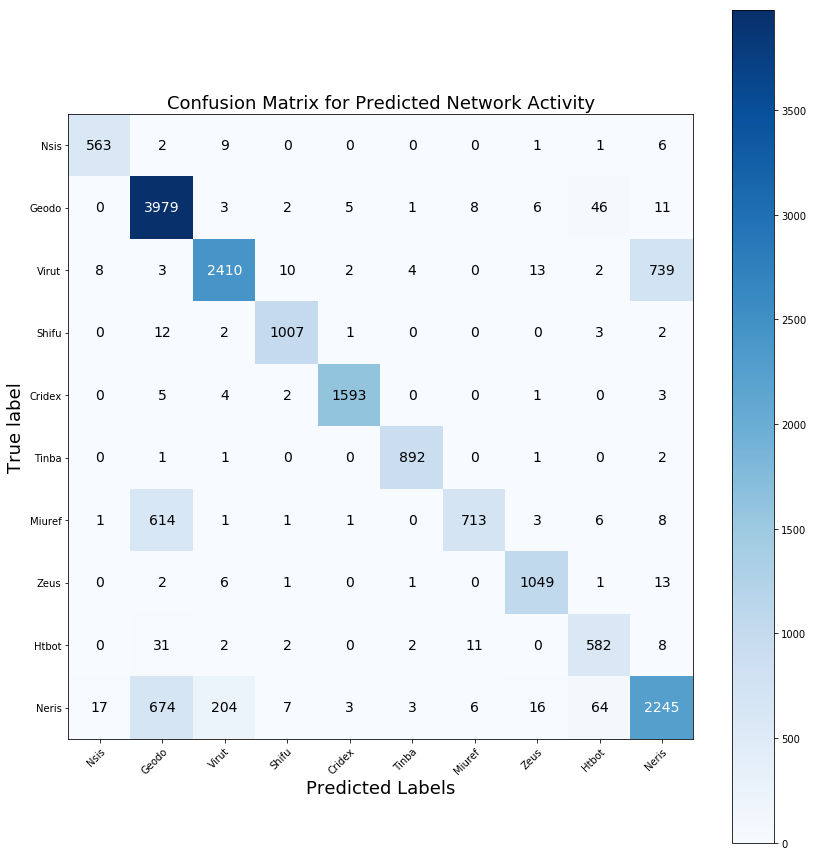

In [0]:
plot_confusion_matrix(n_valid_labels,n_valid_cnn_labels,classes,"RESNET-MAL")